In [1]:
import os
import sys

sys.path.append("C:/Users/wwway/Downloads\cs-sdp-2023-24-main (1)/cs-sdp-2023-24-main/python")

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from data import Dataloader
from models import RandomExampleModel
import metrics

In [3]:
# Loading the data
data_loader = Dataloader("C:/Users/wwway/Downloads/cs-sdp-2023-24-main (1)/cs-sdp-2023-24-main/data/dataset_4") # Specify path to the dataset you want to load
X, Y = data_loader.load()


In [4]:
# Let's train an example model
model = RandomExampleModel() # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

In [5]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[-0.06326043 -0.18471619]
 [-0.20129649 -0.33004454]
 [ 0.00500771 -0.09058298]
 [ 0.07658458  0.12828252]
 [-0.06293998 -0.07432317]]


- Nommons chaque liste de cette matrice L, L[0]= Score du Cluster 1 et L[1] = Score du Cluster 2 
- Chaque ligne correspond à une paire de produits (X,Y), on calcule alors le score de la fonction d'utilité pour chaque paire de produits sur chaque cluster L[0] ou L[1]

In [6]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[0 0]
 [0 0]
 [1 0]
 [1 1]
 [0 0]]


In [7]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 0.8


In [8]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.5845
Percentage of explained preferences for all samples: 0.5845


In [9]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 0 1 0]


In [10]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[0 0 0 1 0]


In [11]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 1.0
Cluster intersection for all samples: 0.6577508754377188
Cluster intersection for all samples: 0.6577508754377188


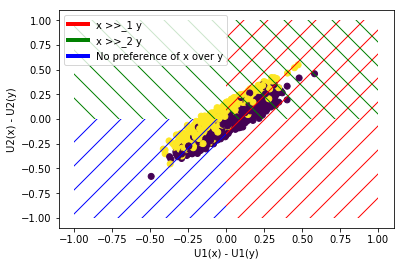

In [12]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

U1 signifie le score utilité du cluster 1 (même chose pour U2)

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [ ]:

# Loading the data
data_loader = Dataloader("../data/dataset_10") # Specify path to the dataset you want to load
X_hard, Y_hard = data_loader.load()
Z_hard = data_loader.get_ground_truth_labels()

cluster_intersection = metrics.ClusterIntersection()
pairs_explained = metrics.PairsExplained()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_diff_x = model.predict_utility(X_hard)
u_diff_y = model.predict_utility(Y_hard)
u_diff = u_diff_x - u_diff_y

u1_diff = u_diff[:, 0]
u2_diff = u_diff[:, 1]
u3_diff = u_diff[:, 2]

# Scatter plot
ax.scatter(u1_diff, u2_diff, u3_diff, c=Z_hard)

ax.set_xlabel("U1(x) - U1(y)")
ax.set_ylabel("U2(x) - U2(y)")
ax.set_zlabel("U3(x) - U3(y)")

plt.show()

In [ ]:
import plotly.graph_objects as go


diff_u1 = model.predict_utility(X_hard)[:, 0] - model.predict_utility(Y_hard)[:, 0]
diff_u2 = model.predict_utility(X_hard)[:, 1] - model.predict_utility(Y_hard)[:, 1]
diff_u3 = model.predict_utility(X_hard)[:, 2] - model.predict_utility(Y_hard)[:, 2]


fig = go.Figure(data=go.Scatter3d(
    x=diff_u1,
    y=diff_u2,
    z=diff_u3,
    mode='markers',
    marker=dict(
        size=8,
        color=Z_hard,               
        colorscale='Viridis',       
        opacity=1.0
    )
))


fig.update_layout(scene=dict(
                    xaxis_title='U1(x) - U1(y)',
                    yaxis_title='U2(x) - U2(y)',
                    zaxis_title='U3(x) - U3(y)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [ ]:
# As an example here are the results obtained with:
""" # Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()
"""
# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")

Your second assignement will be to find a model that will work well with larger data instances.